In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
import seaborn as sns
from scipy.interpolate import griddata
from plotting import plot_equatorial_pacific
from ne_td_utils import clean_jma_data
from sst_utils import csv_from_aqua_modis_dataset, csv_from_avhrp_csv

The NCEI Marine data has no option of narrowing the target data field, i.e longitude and latitude of interest. Since it is of very large size, it was not used.

In [3]:
data = pd.read_csv('data/Marine_CSV_sample.csv')

In [4]:
data.columns

Index(['Identification', 'Latitude', 'Longitude', 'Time of Observation',
       'Ice Accretion On Ship', 'Thickness of Ice Accretion On Ship',
       'Rate of Ice Accretion on Ship', 'Sea Level Pressure',
       'Characteristics of Pressure Tendency', 'Pressure Tendency',
       'Air Temperature', 'Wet Bulb Temperature', 'Dew Point Temperature',
       'Sea Surface Temperature', 'Wave Direction', 'Wave Period',
       'Wave Height', 'Swell Direction', 'Swell Period', 'Swell Height',
       'Total Cloud Amount', 'Low Cloud Amount', 'Low Cloud Type',
       'Cloud Height Indicator', 'Cloud Height', 'Middle Cloud Type',
       'High Cloud Type', 'Visibility', 'Visibility Indicator',
       'Present Weather', 'Past Weather', 'Wind Direction', 'Wind Speed'],
      dtype='object')

In [5]:
data[['Latitude', 'Longitude', 'Time of Observation', 'Sea Surface Temperature']]

,Latitude,Longitude,Time of Observation,Sea Surface Temperature
0,-35.8,2.9,2015-01-12T00:00:00,
1,-35.9,6.9,2015-01-12T12:00:00,
2,-35.9,8.6,2015-01-12T18:00:00,
3,-35.7,11.9,2015-01-13T06:00:00,
4,-35.6,13.7,2015-01-13T12:00:00,
5,-35.4,15.5,2015-01-13T18:00:00,
6,-35.3,17.1,2015-01-14T00:00:00,
7,-35.2,18.6,2015-01-14T06:00:00,
8,-35.2,20.3,2015-01-14T12:00:00,
9,-35.1,21.8,2015-01-14T18:00:00,


Below is monthly data, collected from various stations in particular area, denoted by the coordinates located in the name of the file.

In [6]:
data = pd.read_csv('data/40_130_30_140.csv')

In [7]:
data.columns

Index(['STATION', 'DATE', 'LATITUDE', 'LONGITUDE', 'ELEVATION', 'NAME',
       'IMMA_VER', 'ATTM_CT', 'TIME_IND', 'LL_IND', 'SHIP_COURSE', 'SHIP_SPD',
       'NAT_SOURCE_IND', 'ID_IND', 'COUNTRY_CODE', 'WIND_DIR_IND', 'WIND_DIR',
       'WIND_SPD_IND', 'WIND_SPEED', 'VV_IND', 'VISIBILITY', 'PRES_WX',
       'PAST_WX', 'SEA_LVL_PRES', 'CHAR_PPP', 'AMT_PRES_TEND', 'IND_FOR_TEMP',
       'AIR_TEMP', 'IND_FOR_WBT', 'WET_BULB_TEMP', 'DPT_IND', 'DEW_PT_TEMP',
       'SST_MM', 'SEA_SURF_TEMP', 'TOT_CLD_AMT', 'LOW_CLD_AMT', 'LOW_CLD_TYPE',
       'HGT_IND', 'CLD_HGT', 'MID_CLD_TYPE', 'HI_CLD_TYPE', 'WAVE_DIR',
       'WAVE_PERIOD', 'WAVE_HGT', 'SWELL_DIR', 'SWELL_PERIOD', 'SWELL_HGT',
       'TEN_BOX_NUM', 'ONE_BOX_NUM', 'DECK', 'SOURCE_ID', 'PLATFORM_ID',
       'DUP_STATUS', 'DUP_CHK', 'NIGHT_DAY_FLAG', 'TRIM_FLAG', 'NCDC_QC_FLAGS',
       'EXTERNAL', 'SOURCE_EXCLUSION_FLAG', 'OB_SOURCE', 'OB_PLATFORM',
       'FM_CODE_VER', 'STA_WX_IND', 'PAST_WX2', 'IND_FOR_WAVE_MEAS',
       'DIR_OF_SWELL

In [8]:
data[['STATION', 'DATE', 'LATITUDE', 'LONGITUDE', 'SEA_SURF_TEMP']]

,STATION,DATE,LATITUDE,LONGITUDE,SEA_SURF_TEMP
0,3FBJ7,2004-11-01T00:00:00,30.7,138.60,NaN
1,4XFO,2004-11-01T00:00:00,36.7,132.10,217.0
2,9MCN8,2004-11-01T00:00:00,34.0,139.00,250.0
3,9MET6,2004-11-01T00:00:00,30.1,135.20,251.0
4,A8CN9,2004-11-01T00:00:00,38.1,133.60,201.0
...,...,...,...,...,...
3340,JPBN,2004-11-30T21:00:00,33.0,136.50,212.0
3341,JIFH,2004-11-30T22:00:00,33.9,130.00,203.0
3342,JPBN,2004-11-30T22:00:00,33.0,136.50,211.0
3343,9500,2004-11-30T22:30:00,34.0,130.03,202.0


In [9]:
data.groupby(['DATE', 'LATITUDE', 'LONGITUDE'])['SEA_SURF_TEMP'].mean()

DATE                 LATITUDE  LONGITUDE
2004-11-01T00:00:00  30.1      135.20       251.0
                     30.7      138.60         NaN
                     31.1      134.80       258.0
                     31.8      133.90         NaN
                     34.0      139.00       250.0
                                            ...  
2004-11-30T21:00:00  33.0      136.50       212.0
2004-11-30T22:00:00  33.0      136.50       211.0
                     33.9      130.00       203.0
2004-11-30T22:30:00  34.0      130.03       202.0
2004-11-30T23:00:00  33.1      136.60       211.0
Name: SEA_SURF_TEMP, Length: 3344, dtype: float64

In [10]:
data['SEA_SURF_TEMP'][data['LATITUDE'] < 0]

Series([], Name: SEA_SURF_TEMP, dtype: float64)

In [11]:
data['LATITUDE'].max()

39.99

Below is monthly data downloaded from the https://neo.gsfc.nasa.gov/ website. It is monthly data in .nc format.

In [12]:
# reading the dataset for month of July 2024
# dataset = xr.open_dataset('data/aqua_modis.20240701_20240731.L3m.MO.SST.sst.9km.nc')

In [13]:
dataset = xr.open_dataset('data/aqua_modis/lanina/2010/AQUA_MODIS.20101201_20101231.L3m.MO.SST.sst.9km.nc')

In [14]:
# reading all variables
dataset.variables

Frozen({'sst': <xarray.Variable (lat: 2160, lon: 4320)> Size: 37MB
[9331200 values with dtype=float32]
Attributes:
    long_name:      Sea Surface Temperature
    units:          degree_C
    standard_name:  sea_surface_temperature
    valid_min:      -1000
    valid_max:      10000
    display_scale:  linear
    display_min:    -2.0
    display_max:    45.0, 'qual_sst': <xarray.Variable (lat: 2160, lon: 4320)> Size: 37MB
[9331200 values with dtype=float32]
Attributes:
    long_name:  Quality Levels, Sea Surface Temperature
    valid_min:  0
    valid_max:  5, 'lat': <xarray.IndexVariable 'lat' (lat: 2160)> Size: 9kB
array([ 89.958336,  89.875   ,  89.79167 , ..., -89.791664, -89.87501 ,
       -89.958336], dtype=float32)
Attributes:
    long_name:      Latitude
    units:          degrees_north
    standard_name:  latitude
    valid_min:      -90.0
    valid_max:      90.0, 'lon': <xarray.IndexVariable 'lon' (lon: 4320)> Size: 17kB
array([-179.95833, -179.875  , -179.79166, ...,  179.

Will have to make trasformation on the dataset in order to get the data needed

In [15]:
# extracting to pandas dataframe
raw_data = dataset['sst'].to_dataframe()

# droping the multiindex
tidy_data = raw_data.reset_index()

# filtering lat[20S; 20N]
tidy_data = tidy_data[(tidy_data.lat >= -20) & (tidy_data.lat <= 20)]

# filtering long[130E -> 180 -> -80 W]
tidy_data = tidy_data[(tidy_data.lon >= -180) & (tidy_data.lon <= -80) | (tidy_data.lon >= 130) & (tidy_data.lon <= 180)]

# droping na values
tidy_data = tidy_data.dropna()

# rounding lats and long to 0.5 deg
def round_to_nearest_half(x):
    return np.round(x * 2) / 2

tidy_data.lat = tidy_data.lat.apply(round_to_nearest_half)
tidy_data.lon = tidy_data.lon.apply(round_to_nearest_half)

# grouping by lat and long and averaging the sst
tidy_data = tidy_data.groupby(['lat', 'lon']).sst.mean()

# dropping multiindex
tidy_data = tidy_data.reset_index()

# getting the month
current_month = dataset.attrs['time_coverage_start']

# convert the string to pd.Timestamp object
current_month = pd.to_datetime(current_month)

# normalize timestamp
current_month = current_month.normalize()

# set the month as index of the cleaned data
tidy_data.index = pd.Index([current_month] * len(tidy_data))

In [16]:
# rounding the sst
# raw_data.sst.round(1)
# since the .round() is not working as expected, np used
# np.round(raw_data.sst, 1)
# since np is not working, using apply
tidy_data.sst = tidy_data.sst.apply(lambda x: round(x, 1))

In [17]:
tidy_data['lon'] = np.where(tidy_data['lon'] < 0, tidy_data['lon'] + 360, tidy_data['lon'])

In [18]:
tidy_data.sort_values(['lat', 'lon'])

,lat,lon,sst
2010-12-01 00:00:00+00:00,-20.0,147.5,29.4
2010-12-01 00:00:00+00:00,-20.0,148.0,27.3
2010-12-01 00:00:00+00:00,-20.0,148.5,26.9
2010-12-01 00:00:00+00:00,-20.0,149.0,27.4
2010-12-01 00:00:00+00:00,-20.0,149.5,27.8
...,...,...,...
2010-12-01 00:00:00+00:00,20.0,278.0,26.5
2010-12-01 00:00:00+00:00,20.0,278.5,26.5
2010-12-01 00:00:00+00:00,20.0,279.0,26.8
2010-12-01 00:00:00+00:00,20.0,279.5,26.8


In [19]:
# getting both the sst and the quality of the observation
combined_raw = dataset[['sst', 'qual_sst']].to_dataframe()

In [20]:
combined_raw = combined_raw.reset_index()

In [21]:
combined_raw.qual_sst.value_counts(dropna=False)

qual_sst
0.0    4915303
NaN    4322907
1.0      86767
2.0       6223
Name: count, dtype: int64

Not explicitly written which is the most reliable observation, however based on common conventions in quality flags, 0.0 is typically used to indicate the highest quality or most reliable observation. For the purpose of the project, the quality of the data is consider to be at sufficient level.

In [22]:
dataset

<xarray.Dataset> Size: 75MB
Dimensions:   (lat: 2160, lon: 4320, rgb: 3, eightbitcolor: 256)
Coordinates:
  * lat       (lat) float32 9kB 89.96 89.88 89.79 89.71 ... -89.79 -89.88 -89.96
  * lon       (lon) float32 17kB -180.0 -179.9 -179.8 ... 179.8 179.9 180.0
Dimensions without coordinates: rgb, eightbitcolor
Data variables:
    sst       (lat, lon) float32 37MB nan nan nan nan nan ... nan nan nan nan
    qual_sst  (lat, lon) float32 37MB nan nan nan nan nan ... nan nan nan nan
    palette   (rgb, eightbitcolor) uint8 768B ...
Attributes: (12/61)
    product_name:                     AQUA_MODIS.20101201_20101231.L3m.MO.SST...
    instrument:                       MODIS
    title:                            MODISA Level-3 Standard Mapped Image
    project:                          Ocean Biology Processing Group (NASA/GS...
    platform:                         Aqua
    temporal_range:                   month
    ...                               ...
    cdm_data_type:                    grid
    keywords:                         Earth Science > Oceans > Ocean Optics >...
    keywords_vocabulary:              NASA Global Change Master Directory (GC...
    data_bins:                        5008293
    data_minimum:                     -1.8000001
    data_maximum:                     39.879696

In [23]:
tidy_data

,lat,lon,sst
2010-12-01 00:00:00+00:00,-20.0,180.0,27.8
2010-12-01 00:00:00+00:00,-20.0,180.5,27.9
2010-12-01 00:00:00+00:00,-20.0,181.0,27.4
2010-12-01 00:00:00+00:00,-20.0,181.5,27.6
2010-12-01 00:00:00+00:00,-20.0,182.0,27.4
...,...,...,...
2010-12-01 00:00:00+00:00,20.0,178.0,26.6
2010-12-01 00:00:00+00:00,20.0,178.5,26.7
2010-12-01 00:00:00+00:00,20.0,179.0,26.8
2010-12-01 00:00:00+00:00,20.0,179.5,26.8


Lets try and plot the data to see how it looks:

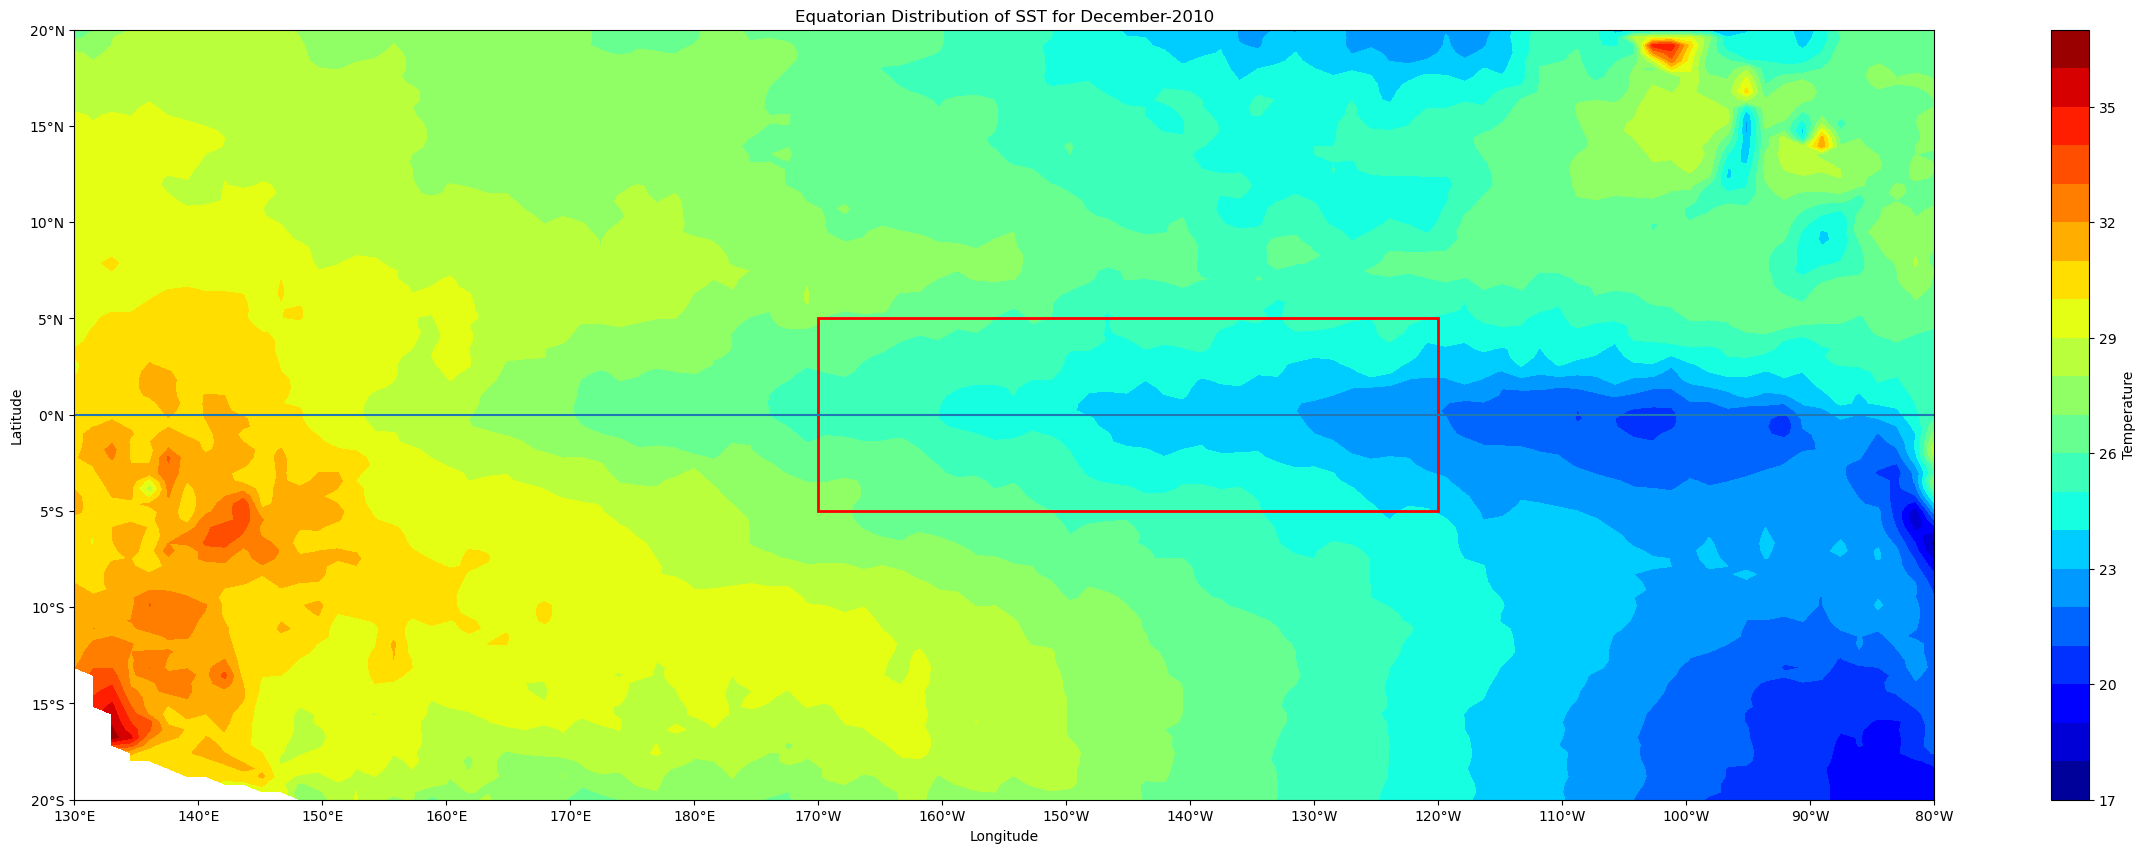

In [24]:
plt.figure(figsize=(30, 10))

# contour map
lon_grid = np.linspace(tidy_data.lon.min(), tidy_data.lon.max(), 100)
lat_grid = np.linspace(tidy_data.lat.min(), tidy_data.lat.max(), 100)
lon_grid, lat_grid = np.meshgrid(lon_grid, lat_grid)
sst_grid = griddata((tidy_data.lon, tidy_data.lat), tidy_data.sst, (lon_grid, lat_grid), method='linear')
plt.contourf(lon_grid, lat_grid, sst_grid, cmap='jet', levels=20)


# plt.scatter(tidy_data.lon, tidy_data.lat, c=tidy_data.sst, cmap='jet', alpha=0.7, s=150, vmin=20, vmax=35)
plt.colorbar(label='Temperature')

x_tick=np.arange(130, 290, 10)
x_label=[f'{x}°E' if x <= 180 else f'{360 - x}°W' for x in x_tick]

y_tick = np.arange(-20, 25, 5)
y_label = [f'{np.abs(x)}°S' if x < 0 else f'{np.abs(x)}°N' for x in y_tick]

box = plt.Rectangle((190, -5), 50, 10, linewidth=2, edgecolor='RED', facecolor='none')
plt.gca().add_patch(box)

plt.axhline(y=0)

plt.xticks(ticks=x_tick, labels=x_label)
plt.yticks(ticks=y_tick, labels=y_label)

plt.xlim(130, 280)
plt.ylim(-20, 20)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title(f'Equatorian Distribution of SST for {current_month.month_name()}-{current_month.year}')  # Title of the plot
plt.show()  # Display the plot

The anomalies observed on the NE and SW quadrants of the diagram are false measurments taken at the earth surface.
We need to extract the python code of reading a dataset and converting it to clean and tidy csv to a function and in addition, to be able to read dirs reccursivly and apply the transformation to all datasets.

The below code is written in a separate module 'utils.py'

In [25]:
# result_list = extract_datasets('data/aqua_modis/elnino/2015/')

In [26]:
# dataset = result_list

In [27]:
# df = create_dataframe('esno_2015', *dataset)

In [28]:
df = pd.read_csv('data/csv_ready/elnino_2015.csv', index_col=0)

After having the combined dataframes I can extract each month data using a 'for' loop and anallyze the data:

In [29]:
for index, data in df.groupby(df.index):
    print(index, data.sst.mean())

2015-10-01 00:00:00+00:00 27.963851508120648
2015-11-01 00:00:00+00:00 28.06992068849139
2015-12-01 00:00:00+00:00 27.97772855756655
2016-01-01 00:00:00+00:00 27.958353020587246


In [30]:
for index, data in df.groupby(df.index):
    print(index, data.sst.median())

2015-10-01 00:00:00+00:00 28.8
2015-11-01 00:00:00+00:00 28.5
2015-12-01 00:00:00+00:00 28.2
2016-01-01 00:00:00+00:00 28.2


This is of no use. I need to filter the data for Niño 3.4 region (5°N-5°S, 170°W-120°W)

In [31]:
df_enso_region = df[(df.lat >= -5) & (df.lat <= 5) | (df.lon >= -170) & (df.lon <= -120)]

In [32]:
df_enso_region.index = pd.to_datetime(df_enso_region.index)

In [33]:
df_enso_region

,lat,lon,sst
2015-10-01 00:00:00+00:00,-5.0,180.0,30.2
2015-10-01 00:00:00+00:00,-5.0,180.5,30.3
2015-10-01 00:00:00+00:00,-5.0,181.0,30.6
2015-10-01 00:00:00+00:00,-5.0,181.5,30.3
2015-10-01 00:00:00+00:00,-5.0,182.0,30.5
...,...,...,...
2016-01-01 00:00:00+00:00,5.0,178.0,28.3
2016-01-01 00:00:00+00:00,5.0,178.5,28.3
2016-01-01 00:00:00+00:00,5.0,179.0,28.1
2016-01-01 00:00:00+00:00,5.0,179.5,28.0


In [34]:
for date, data in df_enso_region.groupby(df_enso_region.index):
    print(date, f'Mean: {data.sst.mean().round(2)}, Median: {data.sst.median()}')

2015-10-01 00:00:00+00:00 Mean: 28.7, Median: 29.3
2015-11-01 00:00:00+00:00 Mean: 29.15, Median: 29.8
2015-12-01 00:00:00+00:00 Mean: 29.06, Median: 29.5
2016-01-01 00:00:00+00:00 Mean: 28.87, Median: 29.1


Lets export plotting of the equatorial pacific ocean to a function

In [35]:
df_enso = df[(df.lat >= -5) & (df.lat <= 5) & (df.lon >= 190) & (df.lon <= 240)]

In [36]:
df.index = pd.to_datetime(df.index)

In [37]:
df.sst = df.sst.apply(lambda x: None if x > 33 else x)

In [38]:
df = df.dropna()

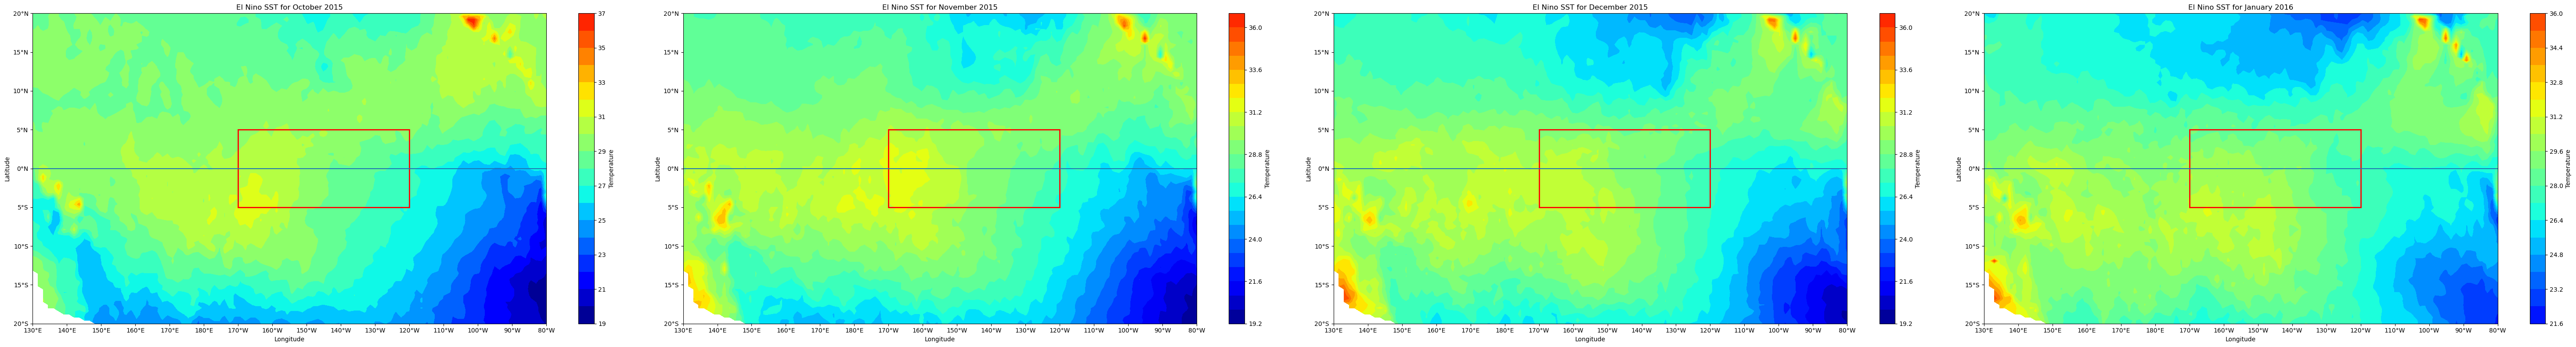

In [39]:
plot_equatorial_pacific(path='data/csv_ready/elnino_2015.csv', cond_name='El Nino')

Found out that my extracting function is not working as expected. Fixed it. I have the dataframe saved as expected.

Lets extract la nina and see how it works:

In [40]:
# lanina = extract_datasets('data/aqua_modis/lanina/2010/')

In [41]:
# lanina = create_dataframe('lanina_2010', *lanina)

In [42]:
lanina = csv_from_aqua_modis_dataset('data/aqua_modis/lanina/2010/', 'lanina_2010')

In [43]:
lanina.sst = lanina.sst.apply(lambda x: None if x > 33 else x)

In [44]:
lanina = lanina.dropna()

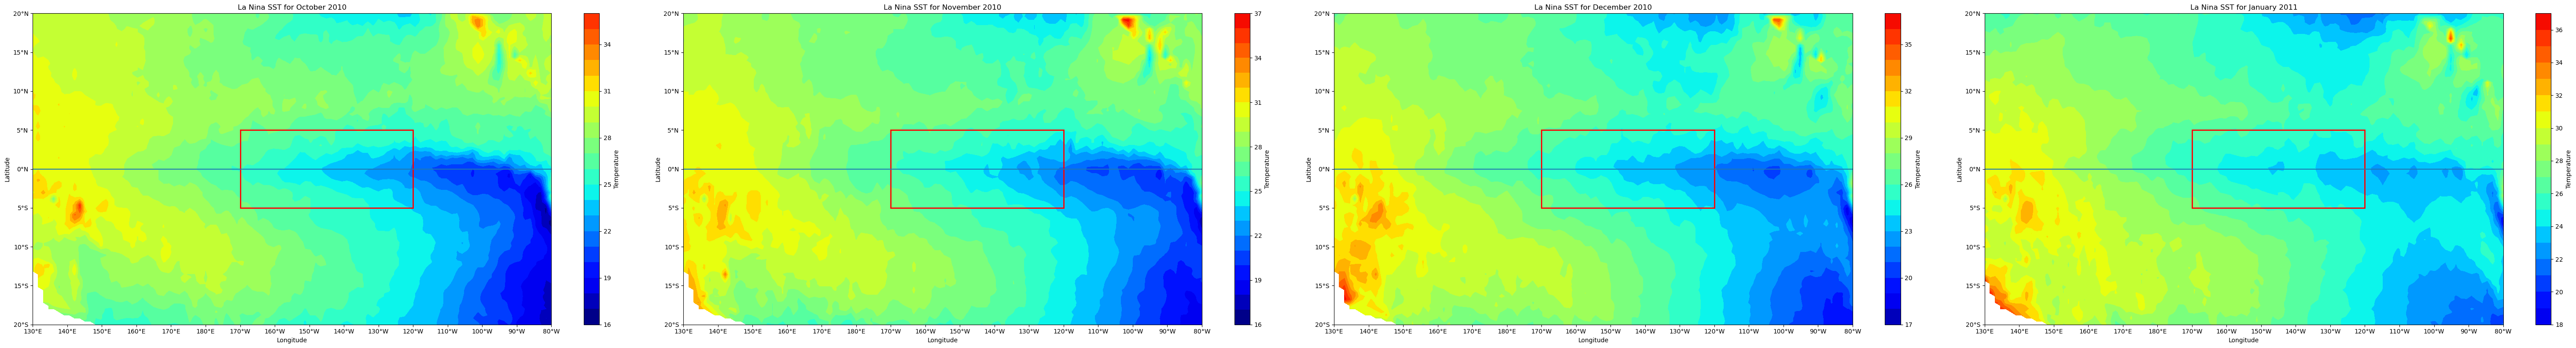

In [45]:
plot_equatorial_pacific('data/csv_ready/lanina_2010.csv', cond_name='La Nina')

The data before 2002 is provided from a different satelite. 
The data is in csv format, without indication of the lats and longs.

In [46]:
df = pd.read_csv('data/aqua_modis/elnino/1997/AVHRR_SST_M_1998-01-01_rgb_720x360.CSV', header=None)
lat = np.arange(-90, 90, 0.5)
lon = np.arange(-180, 180, 0.5)

In [47]:
df.columns = lon

In [48]:
df

,-180.0,-179.5,-179.0,-178.5,-178.0,-177.5,-177.0,-176.5,-176.0,-175.5,...,175.0,175.5,176.0,176.5,177.0,177.5,178.0,178.5,179.0,179.5
0,99999.0,99999.0,99999.0,99999.0,99999.0,99999.0,99999.0,99999.0,99999.0,99999.0,...,99999.0,99999.0,99999.0,99999.0,99999.0,99999.0,99999.0,99999.0,99999.0,99999.0
1,99999.0,99999.0,99999.0,99999.0,99999.0,99999.0,99999.0,99999.0,99999.0,99999.0,...,99999.0,99999.0,99999.0,99999.0,99999.0,99999.0,99999.0,99999.0,99999.0,99999.0
2,99999.0,99999.0,99999.0,99999.0,99999.0,99999.0,99999.0,99999.0,99999.0,99999.0,...,99999.0,99999.0,99999.0,99999.0,99999.0,99999.0,99999.0,99999.0,99999.0,99999.0
3,99999.0,99999.0,99999.0,99999.0,99999.0,99999.0,99999.0,99999.0,99999.0,99999.0,...,99999.0,99999.0,99999.0,99999.0,99999.0,99999.0,99999.0,99999.0,99999.0,99999.0
4,99999.0,99999.0,99999.0,99999.0,99999.0,99999.0,99999.0,99999.0,99999.0,99999.0,...,99999.0,99999.0,99999.0,99999.0,99999.0,99999.0,99999.0,99999.0,99999.0,99999.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
355,99999.0,99999.0,99999.0,99999.0,99999.0,99999.0,99999.0,99999.0,99999.0,99999.0,...,99999.0,99999.0,99999.0,99999.0,99999.0,99999.0,99999.0,99999.0,99999.0,99999.0
356,99999.0,99999.0,99999.0,99999.0,99999.0,99999.0,99999.0,99999.0,99999.0,99999.0,...,99999.0,99999.0,99999.0,99999.0,99999.0,99999.0,99999.0,99999.0,99999.0,99999.0
357,99999.0,99999.0,99999.0,99999.0,99999.0,99999.0,99999.0,99999.0,99999.0,99999.0,...,99999.0,99999.0,99999.0,99999.0,99999.0,99999.0,99999.0,99999.0,99999.0,99999.0
358,99999.0,99999.0,99999.0,99999.0,99999.0,99999.0,99999.0,99999.0,99999.0,99999.0,...,99999.0,99999.0,99999.0,99999.0,99999.0,99999.0,99999.0,99999.0,99999.0,99999.0


In [49]:
df['lat'] = lat

In [50]:
df = df.melt(id_vars='lat', var_name='lon', value_name='sst')

In [51]:
df = df[(df.lat >= -20) & (df.lat <= 20)]

In [52]:
df = df[(df.lon >= -180) & (df.lon <= -80) | (df.lon >= 130) & (df.lon <= 180)]

In [53]:
df = df.reset_index(drop=True)

In [54]:
df.sst = df.sst.apply(lambda x: None if x > 100 else x)

In [55]:
df = df.dropna()

In [56]:
df['lon'] = np.where(df['lon'] < 0, df['lon'] + 360, df['lon'])

It is working as expected. Now to create a python function to read multiple files. Will modify the extract_database() function to read 

In [57]:
date = pd.to_datetime('1998-01')
df.index = pd.Index([date] * len(df))

In [58]:
# plot_equatorial_pacific(df, cond_name='El Nino')

In [59]:
result = csv_from_avhrp_csv('data/aqua_modis/elnino/1997/', 'elnino_1997', '1997-10')

In [60]:
result = result.dropna()

In [61]:
# plot_equatorial_pacific(result, 'El Nino')

Lets see how the temp changes over time for the ENSO region. First we get a function to apply ENSO region filter to the data:

In [62]:
tc_pacific = pd.read_csv('data/hurdat_pacific/hurdat2-nepac-1949-2023-042624.txt')

In [63]:
test = tc_pacific

In [64]:
# drop the index
test = test.reset_index()

In [65]:
# rename columns from 0 to len
test.columns = [i for i in range(len(test.columns))]

In [66]:
# drop columns 8 - end
test = test.drop(columns=[i for i in test.columns[8:]])

In [67]:
# name the columns
test.columns = ['date', 'time', 'consecutive_count', 'type_of_depression', 'lat', 'lon','max_wind_kn', 'min_pressure_mBar']

In [68]:
# changing time col to str 
test.time = test.time.astype(str)

In [69]:
# trimming time col values
test.time = test.time.apply(lambda x: x.strip())

In [70]:
test

,date,time,consecutive_count,type_of_depression,lat,lon,max_wind_kn,min_pressure_mBar
0,19490611,0000,,TS,20.2N,106.3W,45.0,-999.0
1,19490611,0600,,TS,20.2N,106.4W,45.0,-999.0
2,19490611,1200,,TS,20.2N,106.7W,45.0,-999.0
3,19490611,1800,,TS,20.3N,107.7W,45.0,-999.0
4,19490612,0000,,TS,20.4N,108.6W,45.0,-999.0
...,...,...,...,...,...,...,...,...
32401,20231126,1200,,LO,14.4N,123.7W,30.0,1006.0
32402,20231126,1800,,LO,14.3N,124.0W,25.0,1008.0
32403,20231127,0000,,LO,14.1N,124.4W,25.0,1008.0
32404,20231127,0600,,LO,13.8N,124.7W,25.0,1008.0


In [71]:
def clean_ne_td_data(df):
    # reset index
    df = df.reset_index()
    # rename columns from 0 to len
    df.columns = [i for i in range(len(df.columns))]
    # drop columns 8 - end
    df = df.drop(columns=[i for i in df.columns[8:]])
    # name the columns
    df.columns = ['date', 'time', 'consecutive_count', 'type_of_depression', 'lat', 'lon', 'max_wind_kn',
                  'min_pressure_mBar']

    # modify the time
    df.time = df.time.astype(str)
    df.time = df.time.apply(lambda x: x.strip())

    # adding columns, removing non-observation entries
    df = export_name_basin_count(df)

    # continue to modify time
    df.time = df.time.apply(lambda x: x[0:2] + ':' + x[2:] + ':00')
    df.time = pd.to_timedelta(df.time)

    # strip the column, drop non-valid values and convert to int
    df.consecutive_count = df.consecutive_count.apply(lambda x: x.strip())
    df = df.drop(df.index[~df.consecutive_count.str.isdigit()])
    df = df.drop(df.index[~df.date.str.isdigit()])
    df.consecutive_count = df.consecutive_count.astype(int)

    # modify date, concatenate with time and set as index
    df.date = pd.to_datetime(df.date)
    df.date = df.date + df.time
    df.index = pd.Index(df.date)

    # drop the time and date
    df = df.drop(columns=['time', 'date'])
    
    # set the lat and lon
    df.lat = df.lat.apply(convert_lat_lon_to_number)
    df.lon = df.lon.apply(convert_lat_lon_to_number)

    # rearrange cols
    df = df[['basin', 'name', 'consecutive_count', 'type_of_depression', 'lat', 'lon', 'max_wind_kn',
       'min_pressure_mBar']]
    
    return df

def convert_lat_lon_to_number(value):
    return float(value[:-1]) if (value[-1] == 'N' or value[-1] == 'E') else float(value[:-1]) * -1 + 360

def export_name_basin_count(df):
    # adding additional cols for the type, name
    df['basin'] = pd.Series()
    df['name'] = pd.Series()
    
    # getting the rows with names
    names = df[~df.time.str.isdigit()]

    for index in names.index:
        basin = str(names.loc[index, 'date'])[:2]
        name = names.loc[index, 'time']
        count = names.loc[index, 'consecutive_count']

        start_index = index + 1
        while df.loc[start_index, 'time'].isdigit():
            df.loc[start_index, 'basin'] = basin
            df.loc[start_index, 'name'] = name
            df.loc[start_index, 'consecutive_count'] = count
            start_index += 1
            if start_index > df.index[-1]:
                break
        df = df.drop(index)
    return df

In [72]:
test = export_name_basin_count(test)

In [73]:
test

,date,time,consecutive_count,type_of_depression,lat,lon,max_wind_kn,min_pressure_mBar,basin,name
0,19490611,0000,,TS,20.2N,106.3W,45.0,-999.0,NaN,NaN
1,19490611,0600,,TS,20.2N,106.4W,45.0,-999.0,NaN,NaN
2,19490611,1200,,TS,20.2N,106.7W,45.0,-999.0,NaN,NaN
3,19490611,1800,,TS,20.3N,107.7W,45.0,-999.0,NaN,NaN
4,19490612,0000,,TS,20.4N,108.6W,45.0,-999.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
32401,20231126,1200,25,LO,14.4N,123.7W,30.0,1006.0,EP,RAMON
32402,20231126,1800,25,LO,14.3N,124.0W,25.0,1008.0,EP,RAMON
32403,20231127,0000,25,LO,14.1N,124.4W,25.0,1008.0,EP,RAMON
32404,20231127,0600,25,LO,13.8N,124.7W,25.0,1008.0,EP,RAMON


In [74]:
# strip the column and convert to int
test.consecutive_count = test.consecutive_count.apply(lambda x: x.strip())

In [75]:
# for this dropping non-valid rows
test = test.drop(test.index[~test.consecutive_count.str.isdigit()])
test = test.drop(test.index[~test.date.str.isdigit()])

In [76]:
# setting the type of the col
test.consecutive_count = test.consecutive_count.astype(int)

In [77]:
test.type_of_depression = test.type_of_depression.apply(lambda x: str(x).strip())

In [78]:
test.date = pd.to_datetime(test.date)

In [79]:
test.time = test.time.apply(lambda x: x[0:2] + ':' + x[2:] + ':00')

In [80]:
test.time = pd.to_timedelta(test.time)

In [81]:
test.date = test.date + test.time

In [82]:
test.index = pd.Index(test.date)

In [83]:
test = test.drop(columns=['time', 'date'])

In [84]:
def convert_lat_lon_to_number(value):
    return float(value[:-1]) if (value[-1] == 'N' or value[-1] == 'E') else float(value[:-1]) * -1 + 360

In [85]:
test.lat = test.lat.apply(convert_lat_lon_to_number)
test.lon = test.lon.apply(convert_lat_lon_to_number)

Now, it looks that the data is cleaned and tydied. We export all in function

In [86]:
test.min_pressure_mBar.min()

-999.0

In [87]:
test2 = tc_pacific[-80:]

In [88]:
test_2 = pd.read_csv('data/hurdat_pacific/hurdat2-nepac-1949-2023-042624.txt')

In [89]:
# tt = clean_ne_td_data(test_2)

In [90]:
# tt.to_csv('data/csv_ready/ne_pacific_td.csv')

In [91]:
tt = pd.read_csv('data/csv_ready/ne_pacific_td.csv', index_col=0)

In [92]:
tt = tt.drop(tt.index[tt.min_pressure_mBar == -999])

In [93]:
tt.index = pd.to_datetime(tt.index)

In [94]:
tt[tt.index.year == 1959][-50:]

,basin,name,consecutive_count,type_of_depression,lat,lon,max_wind_kn,min_pressure_mBar
date,,,,,,,,
1959-08-03 00:00:00,CP,DOT,27,HU,15.3,214.3,130.0,952.0
1959-09-24 18:00:00,EP,UNNAMED,19,HU,22.1,237.6,70.0,967.0
1959-10-27 12:00:00,EP,UNNAMED,24,HU,19.1,255.6,120.0,958.0


Time to clean the JMA data. It is not in very convenient format se we need to adjust for the columns

In [95]:
header_col_space = [5, 4, 3, 4, 4, 1, 20, 8]
extract_names = pd.read_fwf('data/jma_data/bst_all.txt', widths=header_col_space, header=None)

In [96]:
names = extract_names[extract_names[0] == 66666]

In [97]:
names

,0,1,2,3,4,5,6,7
0,66666,510,1,10,NaN,NaN,5101 0 6,NaN
11,66666,510,2,37,NaN,NaN,5102 0 6,GEORGI
49,66666,510,3,36,NaN,NaN,5103 0 6,HOP
86,66666,510,4,66,NaN,NaN,5104 0 6,IRI
153,66666,510,5,45,NaN,NaN,5105 1 0,JOA
...,...,...,...,...,...,...,...,...
71067,66666,231,3,019,0015,NaN,2313 0 6,YUN-YEUN
71087,66666,231,4,046,0016,NaN,2314 0 6,KOIN
71134,66666,231,5,039,0017,NaN,2315 1 0,BOLAVE
71174,66666,231,6,013,0018,NaN,2316 0 6,SANB


In [98]:
data_col_space = [8, 4, 2, 4, 5, 5, 13] # manually adjustd
full_data = pd.read_fwf('data/jma_data/bst_all.txt', widths=data_col_space, header=None, dtype='str')

In [99]:
full_data[-50:]

,0,1,2,3,4,5,6
71151,23101006,002,5,144,1457,975,070
71152,23101012,002,5,151,1449,970,075
71153,23101018,002,5,160,1445,955,085
71154,23101100,002,5,171,1440,935,100
71155,23101106,002,5,182,1434,910,110
71156,23101112,002,5,189,1430,905,115
71157,23101118,002,5,197,1428,905,115
71158,23101200,002,5,206,1429,905,115
71159,23101206,002,5,218,1434,905,115
71160,23101212,002,5,227,1443,905,115


In [100]:
# def clean_jma_data(data_path='data/jma_data/bst_all.txt'):
#     # read the data and extract the header rows 
#     header_col_space = [5, 4, 3, 4, 4, 1, 20, 8]
#     extract_names = pd.read_fwf(data_path, widths=header_col_space, header=None)
#     names = extract_names[extract_names[0] == 66666]

#     # read the data and extract the header rows. the column space is manually adjusted
#     data_col_space = [8, 4, 2, 4, 5, 5, 13]
#     full_data = pd.read_fwf(data_path, widths=data_col_space, header=None, dtype='str')

#     # create a column to contain the names
#     full_data['name'] = pd.Series()

#     for index in names.index:
#         name = names.loc[index, 7]

#         start_index = index + 1
#         while True:
#             full_data.loc[start_index, 'name'] = name
#             start_index += 1
#             if start_index > full_data.index[-1]:
#                 break
#             if start_index in names.index:
#                 break
#         full_data = full_data.drop(index)

#     col_names = ['date', 'indicator', 'category', 'lat', 'lon', 'min_pressure_mBar', 'max_wind_kn', 'name']
#     full_data.columns = col_names
#     full_data = full_data.drop(columns='indicator')

#     full_data = cleaning_jma_columns(full_data)
#     full_data = modify_jma_date(full_data)

#     save_data(full_data, 'jma_td.csv')

#     return full_data

In [101]:
data = clean_jma_data()

In [104]:
data

,category,lat,lon,min_pressure_mBar,max_wind_kn,name
date,,,,,,
1951-02-19 06:00:00,2,20.0,138.5,1010,0,NaN
1951-02-19 12:00:00,2,20.0,138.5,1010,0,NaN
1951-02-19 18:00:00,2,23.0,142.1,1000,0,NaN
1951-02-20 00:00:00,9,25.0,146.0,994,0,NaN
1951-02-20 06:00:00,9,27.6,150.6,994,0,NaN
...,...,...,...,...,...,...
2023-12-17 06:00:00,3,7.5,129.6,1002,35,JELAWA
2023-12-17 12:00:00,3,7.4,128.5,1002,35,JELAWA
2023-12-17 18:00:00,3,7.4,127.4,1002,35,JELAWA


In [105]:
# df = data

In [106]:
# df = df.drop(columns='indicator')

KeyError: "['indicator'] not found in axis"

In [ ]:
# df.max_wind_kn = df.max_wind_kn.apply(lambda x: '000' if pd.isna(x) else x)

In [ ]:
# df.max_wind_kn = df.max_wind_kn.astype('int')

In [ ]:
# df.min_pressure_mBar = df.min_pressure_mBar.astype(int)

In [ ]:
# df.lat = df.lat.astype(int).apply(lambda x: x / 10)

In [ ]:
# df.lon = df.lon.astype(int).apply(lambda x: x / 10)

In [ ]:
# df.date = df.date.apply(jma_date_time)

In [ ]:
# df.index = pd.Index(df.date)

In [ ]:
# df.to_csv('data/csv_ready/jma_td.csv')

In [ ]:
# df = df.drop(columns='date')

In [ ]:
def save_data(data, filename):
    try:
        data.to_csv(f'data/csv_ready/{filename}.csv')
    except OSError:
        print('Error saving file')

def modify_jma_date(df):
    df.date = df.date.apply(jma_date_time)
    df.index = pd.Index(df.date)
    df = df.drop(columns='date')

    return df


def cleaning_jma_columns(df):
    # wind column
    df.max_wind_kn = df.max_wind_kn.apply(lambda x: '000' if pd.isna(x) else x)
    df.max_wind_kn = df.max_wind_kn.astype('int')

    # pressure column
    df.min_pressure_mBar = df.min_pressure_mBar.astype(int)

    # latitude
    df.lat = df.lat.astype(int).apply(lambda x: x / 10)

    # longitude
    df.lon = df.lon.astype(int).apply(lambda x: x / 10)

    return df


def jma_date_time(value):
    """ will be applied to all values in the column """

    date = value[:-2]
    time = value[-2:]

    time = pd.Timedelta(hours=int(time))

    date = f'{date[:2]}-{date[2:4]}-{date[-2:]}'

    if int(date[:2]) < 51:
        date = '20' + date
    else:
        date = '19' + date

    date = pd.to_datetime(date)

    date += time

    return date

In [ ]:
df_final = clean_jma_data()

In [ ]:
# df_final.to_csv('data/csv_ready/jma_td.csv')

In [ ]:
jma = pd.read_csv('data/csv_ready/jma_td.csv', index_col=0)

In [ ]:
jma.index = pd.to_datetime(jma.index)

Now that we have the complete data for the TD in north pacific, I will get geo data and convert it to csv so I can plot N Pacific

In [ ]:
jma[(jma.name == 'BOLAVE') & (jma.index.year == 2023)]

In [ ]:
jma[jma.index.year == 2023].groupby(['name']).value_counts()

In [ ]:
gdf = pd.read_csv('data/csv_ready/gdf_csv.csv')

In [ ]:
gdf = gdf.drop(columns=['id', 'source', 'level', 'parent_id', 'sibling_id', 'area', 'geometry'])

In [ ]:
gdf = gdf.drop(columns='geometry')

In [ ]:
gdf.lon = gdf.lon.apply(lambda x: x + 360 if x < 0 else x)

In [ ]:
gdf = gdf[gdf.lat <= 45]

In [ ]:
gdf = gdf[gdf.lat >= -20]

In [ ]:
gdf = gdf[gdf.lon >= 100]

In [ ]:
gdf = gdf[gdf.lon <= 290]

In [ ]:
plt.figure(figsize=(30, 10))
plt.scatter(gdf.lon, gdf.lat, s=0.5)

plt.show()

In [ ]:
# gdf.to_csv('data/csv_ready/gdf_pacific.csv', index=False)

In [ ]:
pd.read_csv('data/csv_ready/gdf_pacific.csv')

In [ ]:
jma_2023 = jma[jma.index.year == 2023]

In [ ]:
jma_2023[jma_2023.name == 'KHANU']

In [ ]:
plt.figure(figsize=(30, 10))
plt.scatter(gdf.lon, gdf.lat, s=0.5)

for td_name, values in jma_2023.groupby('name'):
    plt.plot(values['lon'], values['lat'], label=td_name)    

plt.show()

In [ ]:
from sst_utils import read_files, dataset_to_csv
from plotting import plot_equatorial_pacific

In [ ]:
result = read_files(directory_name='data/aqua_modis/neutral/', ext='nc')
# neutral_csv = dataset_to_csv('neutral_2012', result)

In [ ]:
neutral = pd.read_csv('data/csv_ready/neutral_2012.csv', index_col=0)

In [ ]:
neutral.index = pd.to_datetime(neutral.index)

In [ ]:
neutral.index = pd.to_datetime(neutral.index)neutral.index = pd.to_datetime(neutral.index)

In [ ]:
elnino = pd.read_csv('data/csv_ready/elnino_2015.csv', index_col=0)
elnino.index = pd.to_datetime(elnino.index)

In [ ]:
elnino

In [ ]:
# result = read_files(directory_name='data/aqua_modis/lanina/2010/', ext='nc')
# lanina = dataset_to_csv('lanina_2010', result)

In [ ]:
table = pd.read_table('data/year_period.txt', header=None)

In [ ]:
cols = ['date', 'djf','jfm','fma','mam','amj','mjj','jja','jas','aso','son','ond','ndj']
table.columns = cols

In [ ]:
table['enso'] = pd.Series()

In [ ]:
table.loc[0, 'enso'] = -1

In [ ]:
def apply_enso(df):
    for i in range(len(df)):
        if i == 0:
            continue
        if df.ndj[i - 1] > 0.5:
            df.loc[i, 'enso'] = 1
        elif df.ndj[i - 1] < -0.5:
            df.loc[i, 'enso'] = -1
        else:
            df.loc[i, 'enso'] = 0
    return df
table = apply_enso(table)

In [ ]:
table.enso.value_counts()

In [ ]:
cols = ['date', 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 'enso']

In [ ]:
table.columns = cols

In [ ]:
table = table.melt(id_vars=['date', 'enso'], var_name='month', value_name='sst_anomaly').sort_values(['date', 'month'])

In [ ]:
def concat_year_month(df):
    df.date = df.date.astype(str)
    df.month = df.month.astype(str)
    for i in range(len(df)):
        month = df.loc[i, 'month']
        year = df.loc[i, 'date']
        if len(month) == 1:
            month = '0' + month
        df.loc[i, 'date'] = f'{year}-{month}'

    df.date = pd.to_datetime(df.date)
    df.index = pd.Index(df.date)
    df = df.drop(columns=['date','month'])
    return df
table = concat_year_month(table)

In [ ]:
# table.to_csv('data/csv_ready/oni_table.csv')

In [ ]:
table = pd.read_table('data/year_period.txt', header=None)

In [ ]:
cols = ['date', 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
table.columns = cols

In [ ]:
table['sst_anomaly'] = pd.Series()

In [ ]:
def get_four_month_mean_anomaly(df):
    for i in range(len(df)):
        if i - 1 < 0:
            continue
        df.loc[i, 'sst_anomaly'] = (df.loc[i - 1, 10] + df.loc[i - 1, 11] + df.loc[i - 1, 12] + df.loc[i, 1]) / 4

    df = df.drop(columns=[i for i in range(1, 13)])
    return df

In [ ]:
table = get_four_month_mean_anomaly(table)

In [ ]:
# table.to_csv('data/csv_ready/oni_temp.csv', index=False)

In [ ]:
table